In [2]:
# Import libraries
import sys

import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import json

In [3]:
# Setup GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Load Data and Preprocessing

In [4]:
# Import dataset
G = nx.read_graphml( "data/cora/cora.graphml" )

print(G)

Graph with 2708 nodes and 5278 edges


In [5]:
G.graph

{'node_default': {}, 'edge_default': {}}

In [6]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) ) # 1-1432: weights, 1433: subject

[
    "1033",
    {
        "label": "paper",
        "w_0": 0,
        "w_1": 0,
        "w_2": 0,
        "w_3": 0,
        "w_4": 0,
        "w_5": 0,
        "w_6": 0,
        "w_7": 0,
        "w_8": 0,
        "w_9": 1,
        "w_10": 0,
        "w_11": 0,
        "w_12": 0,
        "w_13": 0,
        "w_14": 0,
        "w_15": 0,
        "w_16": 0,
        "w_17": 0,
        "w_18": 0,
        "w_19": 0,
        "w_20": 0,
        "w_21": 0,
        "w_22": 0,
        "w_23": 0,
        "w_24": 0,
        "w_25": 0,
        "w_26": 0,
        "w_27": 0,
        "w_28": 0,
        "w_29": 0,
        "w_30": 0,
        "w_31": 0,
        "w_32": 0,
        "w_33": 0,
        "w_34": 0,
        "w_35": 0,
        "w_36": 0,
        "w_37": 0,
        "w_38": 0,
        "w_39": 0,
        "w_40": 0,
        "w_41": 0,
        "w_42": 0,
        "w_43": 0,
        "w_44": 0,
        "w_45": 0,
        "w_46": 0,
        "w_47": 0,
        "w_48": 0,
        "w_49": 0,
        "w_50"

In [7]:
# NOT NEEDED FOR HOW I'M USING THE DATASET

# rename '1433' to 'subject'
for node in G.nodes():
    G.nodes[node]['subject'] = G.nodes[node].pop("1433")

KeyError: '1433'

In [8]:
print( G.nodes[node]['subject'] )

Genetic_Algorithms


In [12]:
# remove 'feature' from node attributes
for node in G.nodes():
    G.nodes[node].pop("feature")

In [14]:
# for each node, encode weight as a feature
for node in G.nodes():
    enc = [ val for key, val in G.nodes[node].items() if key != 'subject' and key != 'label' ]
    G.nodes[node]['feature'] = enc

In [15]:
for node in G.nodes( data=True ):
    print( node )
    break

('1033', {'label': 'paper', 'w_0': 0, 'w_1': 0, 'w_2': 0, 'w_3': 0, 'w_4': 0, 'w_5': 0, 'w_6': 0, 'w_7': 0, 'w_8': 0, 'w_9': 1, 'w_10': 0, 'w_11': 0, 'w_12': 0, 'w_13': 0, 'w_14': 0, 'w_15': 0, 'w_16': 0, 'w_17': 0, 'w_18': 0, 'w_19': 0, 'w_20': 0, 'w_21': 0, 'w_22': 0, 'w_23': 0, 'w_24': 0, 'w_25': 0, 'w_26': 0, 'w_27': 0, 'w_28': 0, 'w_29': 0, 'w_30': 0, 'w_31': 0, 'w_32': 0, 'w_33': 0, 'w_34': 0, 'w_35': 0, 'w_36': 0, 'w_37': 0, 'w_38': 0, 'w_39': 0, 'w_40': 0, 'w_41': 0, 'w_42': 0, 'w_43': 0, 'w_44': 0, 'w_45': 0, 'w_46': 0, 'w_47': 0, 'w_48': 0, 'w_49': 0, 'w_50': 0, 'w_51': 0, 'w_52': 0, 'w_53': 0, 'w_54': 0, 'w_55': 0, 'w_56': 0, 'w_57': 0, 'w_58': 0, 'w_59': 0, 'w_60': 0, 'w_61': 0, 'w_62': 0, 'w_63': 0, 'w_64': 0, 'w_65': 0, 'w_66': 0, 'w_67': 0, 'w_68': 0, 'w_69': 0, 'w_70': 0, 'w_71': 0, 'w_72': 0, 'w_73': 0, 'w_74': 0, 'w_75': 0, 'w_76': 0, 'w_77': 0, 'w_78': 0, 'w_79': 0, 'w_80': 0, 'w_81': 0, 'w_82': 0, 'w_83': 0, 'w_84': 0, 'w_85': 0, 'w_86': 0, 'w_87': 0, 'w_88': 0, 'w_

Manually verified 1 in: [118, 125, 176, 252, 351, 456, 507, 521, 619, 648, 698, 702, 734, 845, 902, 1205, 1209, 1236, 1352, 1426 ]

In [18]:
# copy graph
from copy import deepcopy
G2 = deepcopy(G)

# remove redundant weight attributes from nodes
for node in G2.nodes():
    for key in G2.nodes[node].keys():
        if key != 'subject' and key != 'label' and key != 'feature':
            G.nodes[node].pop(key)

del G2

In [19]:
# print node attributes
for node in G.nodes( data=True ):
    print( node )
    break

('1033', {'label': 'paper', 'subject': 'Genetic_Algorithms', 'feature': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Now G should have only 2 attributes: 'subject' and 'feature'

In [21]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) )

[
    "1033",
    {
        "label": "paper",
        "subject": "Genetic_Algorithms",
        "feature": [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
       

In [22]:
print( json.dumps( list( G.edges(data=True) )[0:10], indent = 4 ) )

[
    [
        "1033",
        "35",
        {
            "label": "cites"
        }
    ],
    [
        "1033",
        "1034",
        {
            "label": "cites"
        }
    ],
    [
        "1033",
        "1107062",
        {
            "label": "cites"
        }
    ],
    [
        "1033",
        "41714",
        {
            "label": "cites"
        }
    ],
    [
        "1033",
        "45605",
        {
            "label": "cites"
        }
    ],
    [
        "35",
        "103482",
        {
            "label": "cites"
        }
    ],
    [
        "35",
        "103515",
        {
            "label": "cites"
        }
    ],
    [
        "35",
        "1050679",
        {
            "label": "cites"
        }
    ],
    [
        "35",
        "1103960",
        {
            "label": "cites"
        }
    ],
    [
        "35",
        "1103985",
        {
            "label": "cites"
        }
    ]
]


## Create StellarGraph

In [23]:
SG = StellarGraph.from_networkx(
    graph=G, node_type_default="subject", node_features="feature"
)

print( SG.info() )

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]
        Weights: all 1 (default)
        Features: none


In [24]:
# create a node_subjects Pandas Series with node IDs as index and subject as value
node_subjects = pd.Series( [ G.nodes[node]['subject'] for node in G.nodes() ], index = G.nodes() )

In [25]:
# split into train and test sets
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

In [26]:
print( train_subjects )

416867                    Theory
578649        Genetic_Algorithms
14430      Probabilistic_Methods
335042           Neural_Networks
510715     Probabilistic_Methods
                   ...          
1130539               Case_Based
684531           Neural_Networks
1114352          Neural_Networks
1116835          Neural_Networks
1117476       Genetic_Algorithms
Length: 270, dtype: object


In [27]:
from collections import Counter
Counter(train_subjects) # consider imbalance between class

Counter({'Theory': 35,
         'Genetic_Algorithms': 42,
         'Probabilistic_Methods': 42,
         'Neural_Networks': 81,
         'Case_Based': 30,
         'Rule_Learning': 18,
         'Reinforcement_Learning': 22})

In [28]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
test_targets = le.transform(test_subjects)

In [29]:
print( train_targets ) # for each node, the subject is encoded as a number

[[0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


## GraphSAGE model

In [30]:
batch_size = 50
num_samples = [10, 10, 5]

generator = GraphSAGENodeGenerator( SG, batch_size, num_samples)

In [31]:
train_gen = generator.flow( train_subjects.index, train_targets, shuffle = True )

In [32]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32, 16], generator=generator, bias=True, dropout=0.5
)

In [33]:
print( train_targets.shape )

(270, 7)


In [34]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [35]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [36]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [37]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
6/6 - 33s - loss: 1.8592 - acc: 0.2778 - val_loss: 1.7492 - val_acc: 0.3080 - 33s/epoch - 6s/step
Epoch 2/20
6/6 - 29s - loss: 1.7452 - acc: 0.3148 - val_loss: 1.6188 - val_acc: 0.4159 - 29s/epoch - 5s/step
Epoch 3/20
6/6 - 27s - loss: 1.6172 - acc: 0.4667 - val_loss: 1.4704 - val_acc: 0.6600 - 27s/epoch - 5s/step
Epoch 4/20
6/6 - 27s - loss: 1.4662 - acc: 0.6741 - val_loss: 1.3797 - val_acc: 0.7014 - 27s/epoch - 5s/step
Epoch 5/20
6/6 - 28s - loss: 1.3710 - acc: 0.7111 - val_loss: 1.2890 - val_acc: 0.7231 - 28s/epoch - 5s/step
Epoch 6/20
6/6 - 28s - loss: 1.2589 - acc: 0.7889 - val_loss: 1.2223 - val_acc: 0.7358 - 28s/epoch - 5s/step
Epoch 7/20
6/6 - 29s - loss: 1.1587 - acc: 0.8074 - val_loss: 1.1569 - val_acc: 0.7514 - 29s/epoch - 5s/step
Epoch 8/20
6/6 - 28s - loss: 1.0773 - acc: 0.8519 - val_loss: 1.1171 - val_acc: 0.7420 - 28s/epoch - 5s/step
Epoch 9/20
6/6 - 27s - loss: 0.9982 - acc: 0.8667 - val_loss: 1.0677 - val_acc: 0.7482 - 27s/epoch - 4s/step
Epoch 10/20
6/6 - 2

Nonostante `val_loss` presenta un andamento decrescente, il valore assoluto è comunque alto, dato probabilmente dalla imbalance tra i dati di training e di validation.

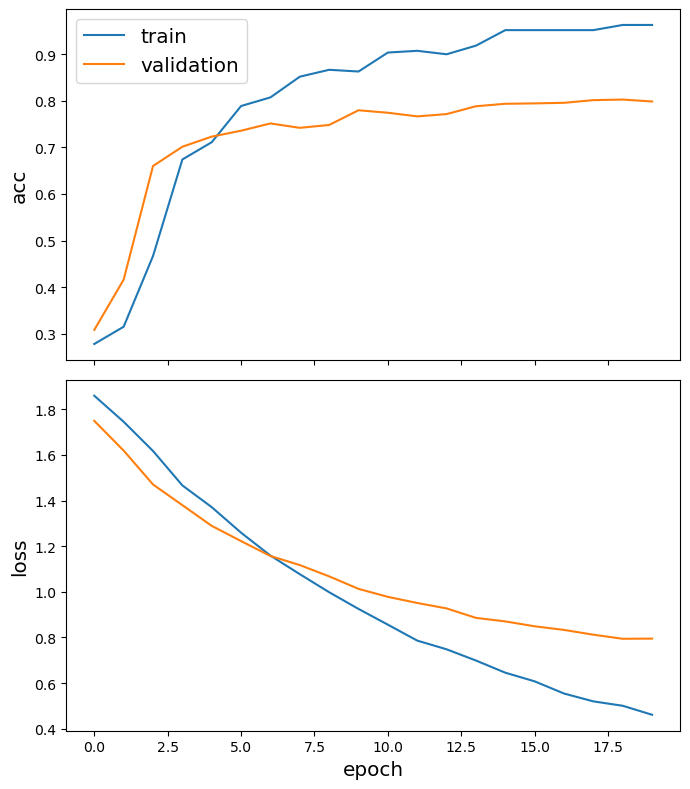

In [38]:
sg.utils.plot_history(history)

In [39]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

49/49 [==============================] - 25s 493ms/step - loss: 0.7835 - acc: 0.7978

Test Set Metrics:
	loss: 0.7835
	acc: 0.7978


In [ ]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

In [ ]:
node_predictions = le.inverse_transform(all_predictions)

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

In [ ]:
# calculate accuracy
df['Correct'] = df['Predicted'] == df['True']
df['Correct'].value_counts()

In [ ]:
accuracy = df['Correct'].value_counts()[True] / df['Correct'].value_counts().sum()
print( accuracy )

## GCN model

In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects, random_state=42
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [ ]:
train_subjects.value_counts().to_frame() # why is equal to demo?

In [ ]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [ ]:
generator = FullBatchNodeGenerator(SG, method="gcn")

In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))